# Lagged Correlation Analysis of Model

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.stats as stats
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import cmocean.cm as cm

In [159]:
mpl.rcParams['figure.dpi']= 100

In [2]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

In [4]:
## adapted from esmtools.stats.corr and xskillscore.pearson_r
## --> https://esmtools.readthedocs.io/en/stable/index.html
## --> https://xskillscore.readthedocs.io/en/stable/index.html

def compute_lagged_corr_monthly(predictand, predictor, maxlead):
    
    predictand = predictand.values
    predictor = predictor.values
        
    ## get length of dimension
    N = predictand.size
    
    ## vector of lead values
    leadvalue = np.asarray(range(maxlead+1))
    
    ## vector of correlation coefficients
    r = np.zeros(maxlead+1)
    ## vector of p-values
    pvalue = np.zeros(maxlead+1)
    
    for (i, lead) in enumerate(leadvalue):
        normal = predictor[0 : N - lead]
        shifted = predictand[0 + lead : N]
        
        r[i], pvalue[i] = stats.pearsonr(normal, shifted)

    return r, pvalue, leadvalue

In [164]:
def lagged_corr_simple_heatmap(predictand_name, predictor_name, reg, threshold=0.75, hatch='//', cmap=cm.balance, figsize=(12,8)):  
    
    predictand = open_metric(predictand_name, 'so', 'anom')
    predictor = open_metric(predictor_name, 'so', 'anom')
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    if reg.lower() != 'all':
        predictand = predictand[reg]
        predictor = predictor[reg]
        
        maxlead = 119
        r, pvalue, leads = compute_lagged_corr_monthly(predictand, predictor, maxlead=maxlead)

        r_matrix = np.zeros((10,12))
        p_matrix = np.zeros((10,12))
        for m in range(r.size):
            r_matrix[int(m/12), m%12] = r[m]
            p_matrix[int(m/12), m%12] = pvalue[m]

        r_matrix = r_matrix.T
        p_matrix = p_matrix.T

        fig,ax = plt.subplots(figsize=figsize)
        im = ax.pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')

        ax.set_title(reg_names[reg])
        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontweight='bold')

        ax.set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
        ax.set_yticklabels(abbrv_month_names)

        ax.set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Year')

        cb = fig.colorbar(im, label='Correlation coefficient', ax=ax)

        if hatch:
            masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
            masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)

        fig.tight_layout()

        return fig, ax
    
    elif reg.lower() == 'all':
        fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
        regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

        for (ix,reg) in enumerate(regions):
            tmp_predictand = predictand[reg]
            tmp_predictor = predictor[reg]
            
            maxlead = 119
            r, pvalue, leads = compute_lagged_corr_monthly(tmp_predictand, tmp_predictor, maxlead=maxlead)
            r_matrix = np.zeros((10,12))
        
            for m in range(r.size):
                r_matrix[int(m/12),m%12] = r[m]

            r_matrix = r_matrix.T

            im = ax[int(ix/3),ix%3].pcolormesh(r_matrix, vmin=-1.0, vmax=1.0, cmap=cmap, shading='auto')

            ax[int(ix/3),ix%3].set_title(reg_names[reg], fontweight='bold')

            ax[int(ix/3),ix%3].set_yticks(np.arange(r_matrix.shape[0]) + 0.5)
            ax[int(ix/3),ix%3].set_yticklabels(abbrv_month_names)

            ax[int(ix/3),ix%3].set_xticks(np.arange(r_matrix.shape[1]) + 0.5)
            ax[int(ix/3),ix%3].set_xticklabels(np.arange(1,11,1))
            ax[int(ix/3),ix%3].set_aspect('auto')

            if int(ix/3) == 1:
                ax[int(ix/3),ix%3].set_xlabel('Year')

            if hatch:
                masked = np.ma.masked_array(r_matrix, mask=np.where(abs(r_matrix) > threshold, 0, 1))
                masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)

        fig.suptitle(var_su_names[predictor_name]+' as a predictor of (leading) '+var_su_names[predictand_name], fontsize=14)
        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist(), label='Correlation coefficient')
        if hatch:
            cb.ax.plot([-1,1], [threshold,threshold], color='k')
            cb.ax.plot([-1,1], [-threshold,-threshold], color='k')
            cb.ax.fill_between([-1,1], [1,1], [threshold,threshold], hatch=hatch, alpha=0)
            cb.ax.fill_between([-1,1], [-threshold,-threshold], [-1,-1], hatch=hatch, alpha=0)
        
        return fig,ax

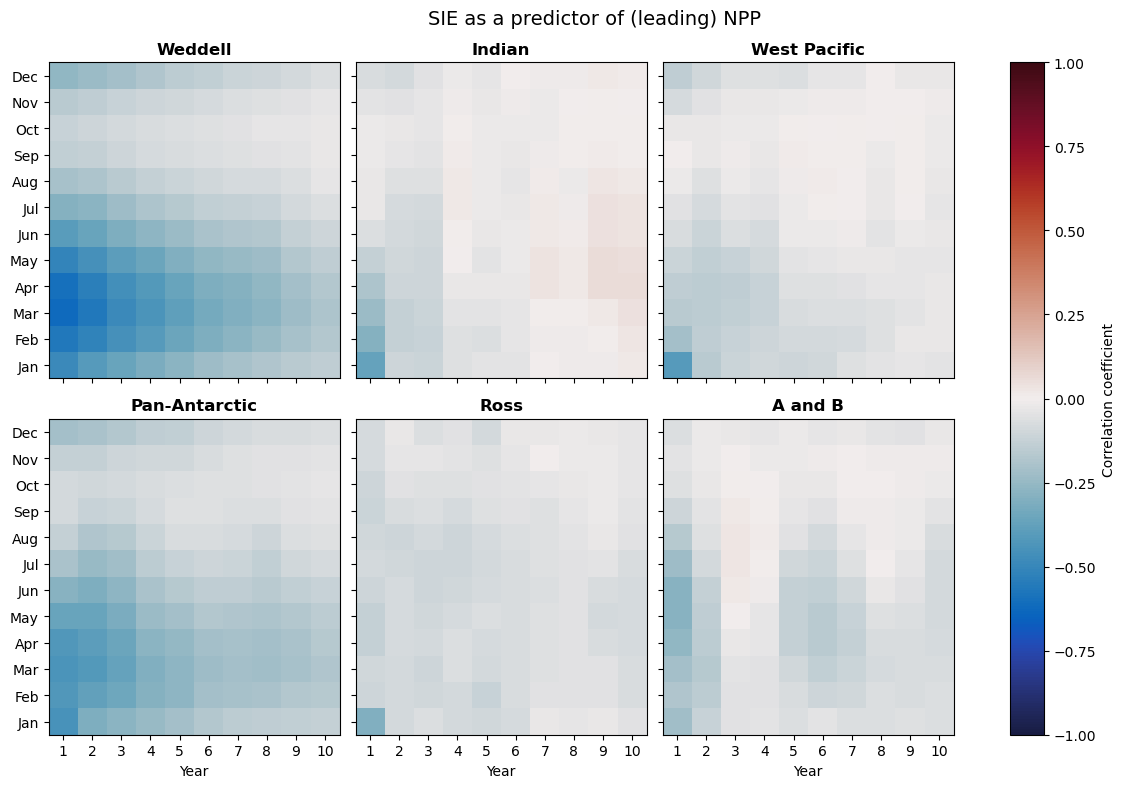

In [167]:
lagged_corr_simple_heatmap('npp', 'sie', 'all', hatch=None);